In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os, copy
import time
import imp

import OMRobjects as OMR
import util_functions as fs

imp.reload(OMR)
imp.reload(fs)

%matplotlib inline

In [37]:
#Set Sheet path
sheet_path = './data/You_to_me_me_to_you'
sheets = fs.get_sheet_list(sheet_path)

* Sheet Object Created :: Sheet #0 :: ./data/You_to_me_me_to_you/p1.png :: (1809, 1280)
* Sheet Object Created :: Sheet #1 :: ./data/You_to_me_me_to_you/p2.png :: (1809, 1280)
* Sheet Object Created :: Sheet #2 :: ./data/You_to_me_me_to_you/p3.png :: (1809, 1280)
* Sheet Object Created :: Sheet #3 :: ./data/You_to_me_me_to_you/p4.png :: (1809, 1280)


>>> Preprocessing Page #00 :: ./data/You_to_me_me_to_you/p1.png
* Deskewing :: PASS
* Resizing :: PASS
* Denoising :: PASS
* Inverse binary thresholding :: threshold=200
>>> Extracting systems : 5 systems
* System Object Created :: System #0 of [...you/p1.png] :: (x, y, w, h) = (83, 188, 1136, 230)
* System Object Created :: System #1 of [...you/p1.png] :: (x, y, w, h) = (79, 479, 1140, 220)
* System Object Created :: System #2 of [...you/p1.png] :: (x, y, w, h) = (80, 773, 1139, 238)
* System Object Created :: System #3 of [...you/p1.png] :: (x, y, w, h) = (83, 1070, 1136, 259)
* System Object Created :: System #4 of [...you/p1.png] :: (x, y, w, h) = (83, 1382, 1137, 247)
>>> Staff line & Bar line removal of System #0 of Sheet #0
* StaffLines Object Created :: Staff Line Cluster #0 with 5 lines :: y = [56 67 78 89 99], average_interval = 11
* StaffLines Object Created :: Staff Line Cluster #1 with 5 lines :: y = [169 180 191 201 212], average_interval = 11


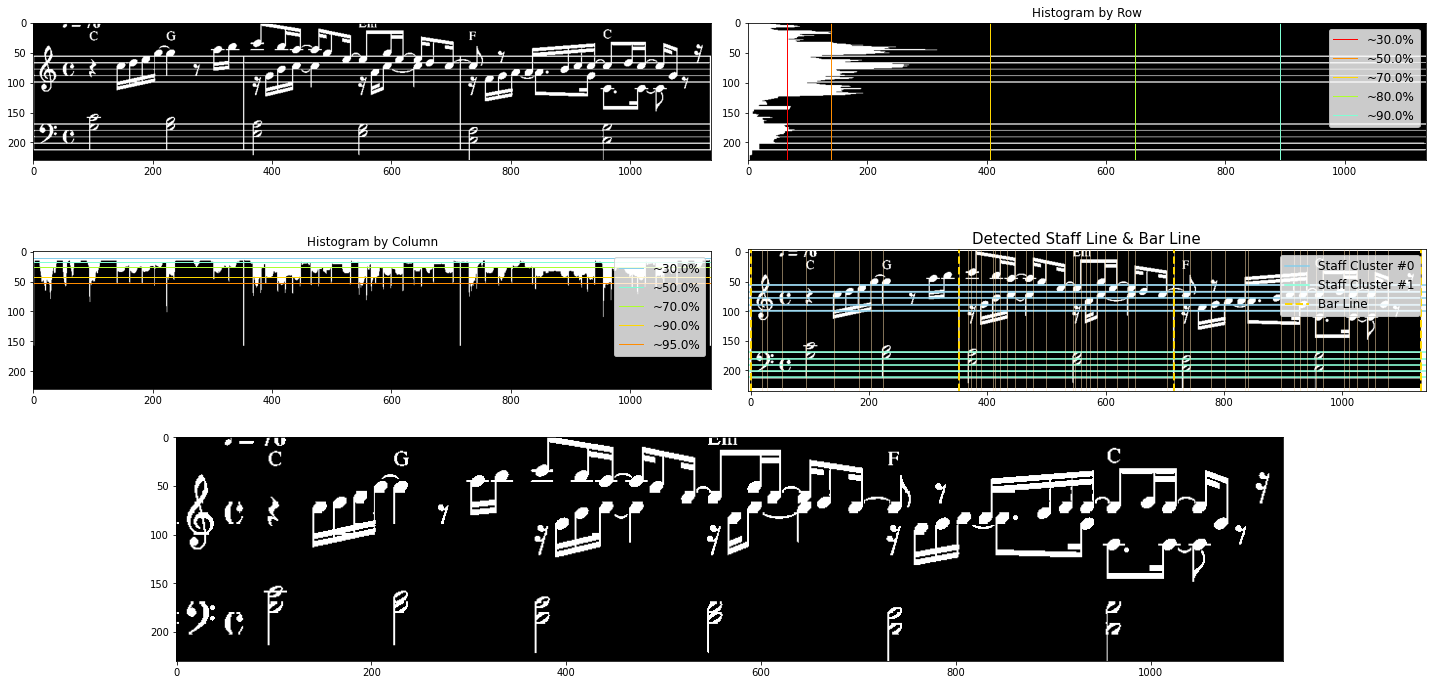

In [39]:
show_plot = True

for sheet_idx, sheet in enumerate(sheets):
    
    sheet.preprocess_image(threshold=200)
    
    #Show Preprocessing result------------------------------------------------------------------
    if False:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 25))
        ax[0].imshow(cv2.cvtColor(sheet.raw_image, cv2.COLOR_BGR2RGB))
        ax[0].set_title(f'Origin of Sheet #{sheet.order}', fontsize=20); ax[0].axis('off')
        ax[1].imshow(sheet.image, cmap='gray')
        ax[1].set_title(f'Preprocessed result of Sheet #{sheet.order}', fontsize=20); ax[1].axis('off')
        fig.tight_layout()
        plt.show()
    #--------------------------------------------------------------------------------------------
    
    sheet.create_system(sheet)
    
    #Show Systems------------------------------------------------------------------
    if False:
        fig = plt.figure(figsize=(20, 25))
        axSheet = plt.subplot2grid((len(sheet.systems), 2), (0, 0), rowspan=len(sheet.systems))
        axSheet.imshow(sheet.image, cmap='gray')
        
        for i, system in enumerate(sheet.systems):
            x, y, w, h = system.basis
            axSheet.add_patch(patches.Rectangle((x, y), w, h, edgecolor='cyan', fill=False, linewidth=3))
            axSheet.text(x, y, f'System #{system.order}', color='cyan', fontsize=25, fontweight='bold')
            
            axSystem = plt.subplot2grid((len(sheet.systems), 2), (i, 1))
            axSystem.imshow(system.image, cmap='gray')
            axSystem.set_anchor('W')                            
        fig.tight_layout()
        plt.show()
    #----------------------------------------------------------------------------------
    
    for system_idx, system in enumerate(sheet.systems):
        print(f'>>> Staff line & Bar line removal of System #{system.order} of Sheet #{sheet.order}')
        
        histogram_r, grid_r, grid_idx_r = system.get_pixel_histogram(depend_on='row')
        histogram_c, grid_c, grid_idx_c = system.get_pixel_histogram(depend_on='col', grid=[0.3, 0.5, 0.7, 0.9, 0.95])

        hline_pos, hthickness = system.get_line_info(hist_by='row')
        vline_pos_, vthickness_ = system.get_line_info(hist_by='col')
        vline_pos, vthickness = system.check_bar()

        system.reset_line_removed_image()
        system.remove_lines(hline_pos, hthickness, direction='hor')
        system.remove_lines(vline_pos, vthickness, direction='ver')
        system.clustering_staff()

        #Show Staff & Bar line------------------------------------------------------------------
        if show_plot:
            fig = plt.figure(figsize=(20,10))
            axOrigin = plt.subplot2grid((3, 2), (0, 0))
            axOrigin.imshow(system.image, cmap='gray')
                
            axr = plt.subplot2grid((3, 2), (0, 1))
            axr.imshow(histogram_r, cmap='gray')
            axr.set_title('Histogram by Row')
            for i, x in enumerate(grid_idx_r):
                axr.axvline(x=x, color=fs.line_opt[i], label=f'~{100*grid_r[i]:.1f}%', linewidth=1)
            axr.legend(fontsize='large', loc='upper right')

            axc = plt.subplot2grid((3, 2), (1, 0))
            axc.imshow(histogram_c, cmap='gray')
            axc.set_title('Histogram by Column')
            for i, y in enumerate(grid_idx_c):
                axc.axhline(y=y, color=fs.line_opt[-(i+1)], label=f'~{100*grid_c[i]:.1f}%', linewidth=1)
            axc.legend(fontsize='large', loc='upper right')
            
            axVis = plt.subplot2grid((3, 2), (1, 1))
            axVis.imshow(system.image, cmap='gray')
            axVis.set_title(f'Detected Staff Line & Bar Line', fontsize=15)
            for staff_idx, staff_lines in enumerate(system.staves):
                axVis.axhline(y=-10, color=fs.line_opt[-(staff_idx+1)], label=f'Staff Cluster #{staff_idx}')
                for y, t in zip(staff_lines.pos, staff_lines.thickness):
                    axVis.axhline(y=y, color=fs.line_opt[-(staff_idx+1)])
            for x, t in zip(vline_pos_, vthickness_):
                axVis.axvline(x=x, color='navajowhite', linewidth=0.5)
            axVis.axvline(x=-10, color='gold', linestyle='--', linewidth=2, label='Bar Line')
            for x, t in zip(vline_pos, vthickness):
                axVis.axvline(x=x, color='gold', linestyle='--', linewidth=2)
            axVis.set_ylim([-5, system.shape[0]+5]); axVis.invert_yaxis()
            axVis.set_xlim([-5, system.shape[1]+5])
            axVis.legend(fontsize='large', loc='upper right')
            
            axRemove = plt.subplot2grid((3, 2), (2, 0), colspan=2)
            axRemove.imshow(system.image_line_removed, cmap='gray')
            
            fig.set_tight_layout(True)
            plt.show()
        #----------------------------------------------------------------------------------
        
        system.create_measure(system)
        
        
        
        
        for measures in 
        
    break

In [22]:
sheets[sample_idx].preprocess_image(threshold=200)
sys_pos = sheets[sample_idx].create_system(sheets[sample_idx])

>>> Preprocessing Page #00 :: ./data/You_to_me_me_to_you/p1.png
* Deskewing :: PASS
* Resizing :: PASS
* Denoising :: PASS
* Inverse binary thresholding :: threshold=200
>>> Extracting systems : 5 systems
* System Object Created:: System #0 of [...you/p1.png] :: (x, y, w, h) = (83, 188, 1136, 230)
* System Object Created:: System #1 of [...you/p1.png] :: (x, y, w, h) = (79, 479, 1140, 220)
* System Object Created:: System #2 of [...you/p1.png] :: (x, y, w, h) = (80, 773, 1139, 238)
* System Object Created:: System #3 of [...you/p1.png] :: (x, y, w, h) = (83, 1070, 1136, 259)
* System Object Created:: System #4 of [...you/p1.png] :: (x, y, w, h) = (83, 1382, 1137, 247)


In [23]:
systems = sheets[sample_idx].systems
sample_idx = 0

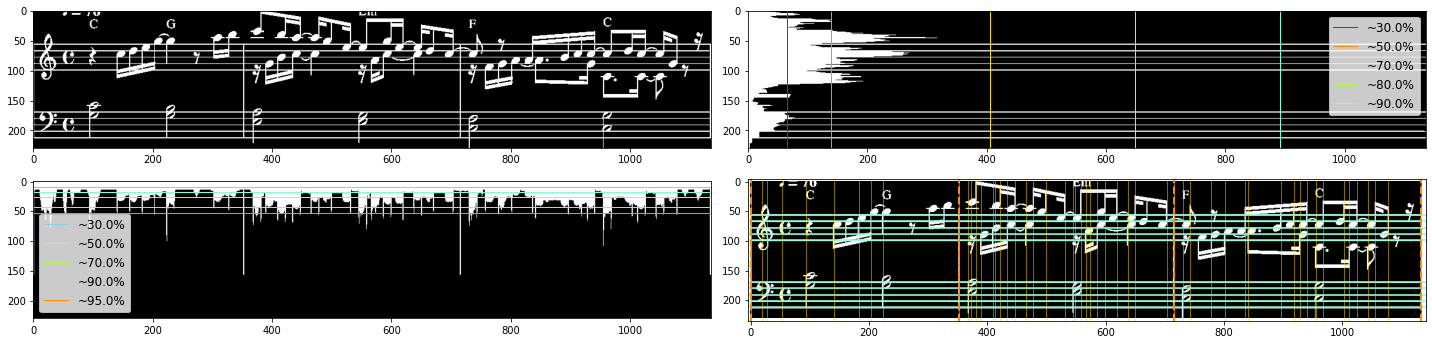

In [24]:
line_opt = ['red', 'darkorange', 'gold', 'greenyellow', 'aquamarine', 'skyblue']

fig = plt.figure(figsize=(20,5))
ax = plt.subplot2grid((2, 2), (0, 0))
ax.imshow(systems[sample_idx].image, cmap='gray')

axVis = plt.subplot2grid((2, 2), (1, 1))
axVis.imshow(systems[sample_idx].image, cmap='gray')

axr = plt.subplot2grid((2, 2), (0, 1))
histogram, grid, grid_idx = systems[sample_idx].get_pixel_histogram(depend_on='row')
axr.imshow(histogram, cmap='gray')

for i, x in enumerate(grid_idx):
    axr.axvline(x=x, color=line_opt[i], label=f'~{100*grid[i]:.1f}%', linewidth=1)
axr.legend(fontsize='large')

hline_pos, hthickness = systems[sample_idx].get_line_info(hist_by='row')
for y, t in zip(hline_pos, hthickness):
    axVis.axhline(y=y, color=line_opt[i])


axc = plt.subplot2grid((2, 2), (1, 0))
histogram, grid, grid_idx = systems[sample_idx].get_pixel_histogram(depend_on='col', grid=[0.3, 0.5, 0.7, 0.9, 0.95])
axc.imshow(histogram, cmap='gray')

for i, y in enumerate(grid_idx):
    axc.axhline(y=y, color=line_opt[-(i+1)], label=f'~{100*grid[i]:.1f}%', linewidth=1)
axc.legend(fontsize='large')

vline_pos, vthickness = systems[sample_idx].get_line_info(hist_by='col')
for x, t in zip(vline_pos, vthickness):
    axVis.axvline(x=x, color=line_opt[-i], linewidth=0.5)
    
vline_pos, vthickness = systems[sample_idx].check_bar()
for x, t in zip(vline_pos, vthickness):
    axVis.axvline(x=x, color=line_opt[-(i+1)], linestyle='--', linewidth=2)
    
axVis.set_ylim([-5, systems[sample_idx].shape[0]+5]); axVis.invert_yaxis()
axVis.set_xlim([-5, systems[sample_idx].shape[1]+5])

fig.set_tight_layout(True)
plt.show()

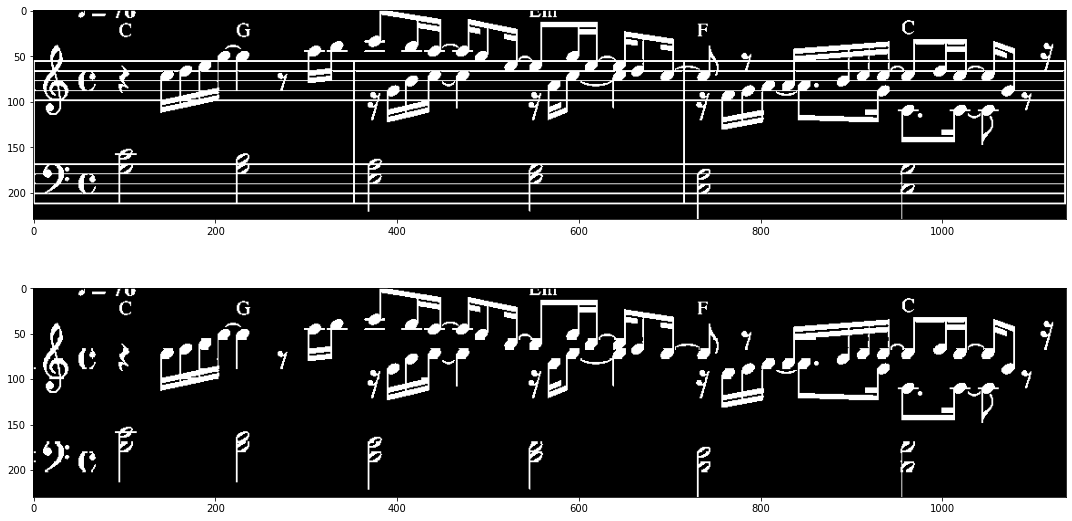

In [25]:
fig = plt.figure(figsize=(15,8))
axt = plt.subplot2grid((2, 1), (0, 0))
axt.imshow(systems[sample_idx].image, cmap='gray')

systems[sample_idx].reset_line_removed_image()
systems[sample_idx].remove_lines(hline_pos, hthickness, direction='hor')
systems[sample_idx].remove_lines(vline_pos, vthickness, direction='ver')

axb = plt.subplot2grid((2, 1), (1, 0))
axb.imshow(systems[sample_idx].image_line_removed, cmap='gray')

fig.set_tight_layout(True)
plt.show()

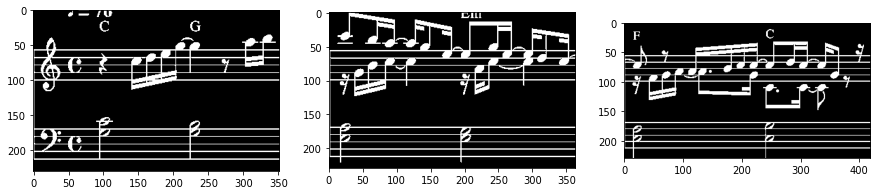

In [26]:
measures = systems[sample_idx].split_into_measures()
    
fig = plt.figure(figsize=(15,8))
for i, m in enumerate(measures):
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(m, cmap='gray')


In [27]:
systems[sample_idx].create_staff_info()
print(len(systems[sample_idx].staves))

for st in systems[sample_idx].staves:
    print('-=-=-=-=-=-=-')
    print(st.pos)
    print(st.thickness)
    print(st.num_line)
    print(st.staff_type)

2
-=-=-=-=-=-=-
[56, 67, 78, 89, 99]
[2, 2, 1, 1, 2]
5
None
-=-=-=-=-=-=-
[169, 180, 191, 201, 212]
[2, 1, 1, 2, 2]
5
None
